This script trains the VGG16 model to recognise VCP pattern from a yearly stock chart.

In [1]:
from pathlib import Path #for reading trained model architecture
import numpy as np
from keras.preprocessing import image
from keras.applications import vgg16
from keras.layers import Dense, Dropout, Flatten
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [4]:
#####################################
#Enter the path of the training data#
#####################################

# Path to folders with training data
vcp_path = Path("./vcp")
not_vcp_path = Path("./non_vcp") 

images = []
labels = []

In [6]:
# Load all the non-vcp images
for img in not_vcp_path.glob("*.png"):
    # Load the image from disk
    img = image.load_img(img)

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'not vcp' image, the label should be 0
    labels.append(0)

In [7]:
# Load all the vcp images
for img in vcp_path.glob("*.png"):
    # Load the image from disk
    img = image.load_img(img)

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'vcp' image, the label should be 1
    labels.append(1)

In [38]:
#Check for total number of data. There should be 504 charts.
len(images)

504

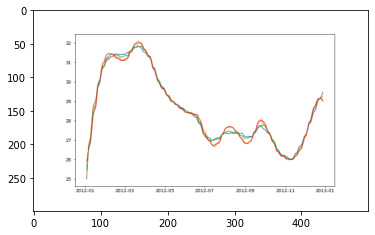

In [40]:
'''
According to the documentation (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.imshow.html#examples-using-matplotlib-pyplot-imshow),

if the input X for imshow(X) is an image array (our case), X has to be an (M,N,3) array with 0-1 float or 0-255 int

In our case, since the RBG values are float numbers (from 0 -255), so we need to rescale the vaules to 0-1 float format
'''
#take a look at one of the chart
plt.imshow(images[0]/255.)


In [41]:
#check the label of the above chart: 0 = non-VCP; 1 = VCP
print(labels[0])

0


In [14]:
# convert the images to a numpy array
X = np.array(images)

# Also convert the labels to a numpy array
y = np.array(labels)

#split the data into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [15]:
#how many images are there in the training set
X_train.shape

(337, 300, 500, 3)

In [16]:
#how many images are there in the validation set
X_test.shape

(167, 300, 500, 3)

In [18]:
# Preprocess the input data 
X_train = vgg16.preprocess_input(X_train)
X_test = vgg16.preprocess_input(X_test)

In [21]:
# Load a pre-trained neural network to use as a feature extractor
# set include_top = False to remove the top layer to be replaced by our own classifier
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(300, 500, 3))

58900480/58889256 [==============================] - 2s 0us/step


In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 125, 128)      0     

In [23]:
# Define the layers in the new classification prediction 
from keras.models import Model
x = base_model.output  
x = Flatten()(x)
x = Dense(128, activation='relu')(x)  
      # new FC layer, random init
x = Dense(128, activation='relu')(x)        # new FC layer, random init
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)  # new sigmoid layer

# Define trainable model which links input from the  base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

# print model structure diagram
print (model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 125, 128)      0     

In [24]:
# Transfer Learning
print ('\nPerforming Transfer Learning')
  #   Freeze all layers in the vgg16 base model 
#because the vgg16 has already been trained
#we don't need to train them again 

for layer in base_model.layers:
  print(layer)
  layer.trainable = False
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Performing Transfer Learning


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 125, 128)      0     

In [27]:
# Train the model
model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_test,y_test)
)

Epoch 1/20
43/43 [==============================] - 147s 3s/step - loss: 10.8462 - accuracy: 0.6944 - val_loss: 6.3032 - val_accuracy: 0.6766
Epoch 2/20
43/43 [==============================] - 115s 3s/step - loss: 4.0603 - accuracy: 0.7864 - val_loss: 3.4663 - val_accuracy: 0.7485
Epoch 3/20
43/43 [==============================] - 106s 2s/step - loss: 1.2805 - accuracy: 0.8724 - val_loss: 1.1761 - val_accuracy: 0.8263
Epoch 4/20
43/43 [==============================] - 103s 2s/step - loss: 0.7718 - accuracy: 0.8635 - val_loss: 1.0477 - val_accuracy: 0.8323
Epoch 5/20
43/43 [==============================] - 104s 2s/step - loss: 0.5562 - accuracy: 0.9199 - val_loss: 1.5523 - val_accuracy: 0.8383
Epoch 6/20
43/43 [==============================] - 104s 2s/step - loss: 1.1111 - accuracy: 0.9139 - val_loss: 3.1746 - val_accuracy: 0.7964
Epoch 7/20
43/43 [==============================] - 104s 2s/step - loss: 0.6350 - accuracy: 0.9288 - val_loss: 2.9903 - val_accuracy: 0.7725
Epoch 8/20
4

In [28]:
#MOST IMPORTANTLY, save the model
model.save('VCP_model_v1.h5') 